# LiH - Confronti tra metodi UCC ~ 22 min

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Array distanze e energie
arr_distance = np.arange(0.75, 4., 0.25) # 13 punti 
arr_ground_energy = {}
arr_intermediate  = {}
arr_results = {}
arr_methods = []
times = {}

## 0 - LiH

In [3]:
from pyscf import gto, scf, fci
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers  import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

In [4]:
def generate_LiH_mol (distance: float = 0.1, basis: str = 'sto3g'):
    LiH = "Li .0 .0 .0; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=LiH,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=False,
        verbose=0
    )
    
    driver = PySCFDriver(
        atom=LiH,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM
    )    
    
    problem = driver.run()
    
    return mol, problem
    
    

### 0.1 - HF e FCI

In [5]:
arr_ground_energy['HF'] = []

arr_ground_energy['FCI'] = []
arr_results['FCI'] = []
arr_methods.append('FCI')

def compute_fci_energy (mol):
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere
    
    n_frozen_orbitals = 1
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0]

    return e_HF, e_FCI

### 0.2 - EfficientSU2

In [6]:
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.mappers import QubitMapper, JordanWignerMapper, ParityMapper

arr_ground_energy['EfficientSU2'] = []
arr_intermediate ['EfficientSU2'] = []
arr_results['EfficientSU2'] = []
arr_methods.append('EfficientSU2')
ini_efficient = None
times['EfficientSU2'] = None

def generate_efficient_ansatz (problem: ElectronicStructureProblem, mapper: JordanWignerMapper()):
    # numero di qubits dell'operatore
    second_q_op = problem.second_q_ops()[0]
    qubit_op = mapper.map(second_q_op)
    num_qubits = qubit_op.num_qubits
    
    efficient = EfficientSU2(num_qubits, entanglement='reverse_linear') 
    
    ini_efficient = [0. for _ in range(efficient.num_parameters)]
    
    return efficient

## 1- UCC Methods

In [7]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC, UCCSD, PUCCD

### 1.1 - UCCS

In [8]:
arr_ground_energy['UCCS'] = []
arr_intermediate ['UCCS'] = []
arr_results['UCCS'] = []
arr_methods.append('UCCS')
ini_uccs = None
times['UCCS'] = None

def generate_uccs_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccs = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='s',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccs = [0. for _ in range(uccs.num_parameters)]
    
    return uccs

### 1.2 - UCCD 

In [9]:
arr_ground_energy['UCCD'] = []
arr_intermediate ['UCCD'] = []
arr_results['UCCD'] = []
arr_methods.append('UCCD')
ini_uccd = None
times['UCCD'] = None

def generate_uccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccd = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='d',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccd = [0. for _ in range(uccd.num_parameters)]
    
    return uccd

### 1.3 - UCCSD

In [10]:
arr_ground_energy['UCCSD'] = []
arr_intermediate ['UCCSD'] = []
arr_results['UCCSD'] = []
arr_methods.append('UCCSD')
ini_uccsd = None
times['UCCSD'] = None

def generate_uccsd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccsd = UCCSD(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        #excitations='sd',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccsd = [0. for _ in range(uccsd.num_parameters)]
    
    return uccsd

### 1.4 - pUCCD

In [11]:
arr_ground_energy['pUCCD'] = []
arr_intermediate ['pUCCD'] = []
arr_results['pUCCD'] = []
arr_methods.append('pUCCD')
ini_puccd = None
times['pUCCD'] = None

def generate_puccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    
    puccd = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_puccd = [0. for _ in range(puccd.num_parameters)]
    
    return puccd

### Aiuti

## 2 - Solver

In [12]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, NFT, L_BFGS_B
from qiskit.primitives import Estimator 
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [13]:
# vettori che andranno a raccogliere i risultati delle varie iterazioni dell'algoritmo
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [14]:
def solve_problem (problem: ElectronicStructureProblem, 
                   ansatz: UCC, 
                   intermediate: list = None,
                   ini: np.ndarray = None, 
                   opt=SLSQP(maxiter=1000), 
                   mapper: QubitMapper = JordanWignerMapper()):
    
    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)
    
    if ini is None:
        ini = [0.0] * ansatz.num_parameters
    else:
        vqe_solver.initial_point = ini
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    # conservo i valori intermedi
    if intermediate is not None:
        intermediate = [counts,values]
    
    
    return res

## 3 - Ex

In [15]:
# Parametri per la risoluzione
# SLSQP(maxiter=10) 22 min ma uccd ancora sballato in d<2.25
# SLSQP() 60 min ma uccsd ancora sballato
opt    = COBYLA() # 49min
mapper = JordanWignerMapper()
basis  = 'sto3g'

# Per conservare i tempi di esecuzione
from time import time

In [16]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
freezer = FreezeCoreTransformer(remove_orbitals=[0])

In [17]:
for distance in arr_distance:
    print('------------------------', distance, '------------------------')
    mol, problem = generate_LiH_mol(distance=distance, basis=basis)
    
    problem = freezer.transform(problem)
    
    # 0 - HF & FCI
    e_HF, e_FCI = compute_fci_energy(mol=mol)
    arr_ground_energy['HF'].append(e_HF)
    arr_ground_energy['FCI'].append(e_FCI)
    
    print('HF:  ', e_HF)
    print('FCI: ', e_FCI)
    
    # 0.1 - EfficientSU2
    start_time = time()
    efficient = generate_efficient_ansatz(problem=problem,
                                          mapper=mapper
                                         )
    efficient_res = solve_problem(problem=problem,
                                  ansatz=efficient, 
                                  intermediate=arr_intermediate['EfficientSU2'],
                                  ini=ini_efficient,
                                  opt=opt,
                                  mapper=mapper
                                 )
    
    # conservo il result
    arr_results['EfficientSU2'].append(efficient_res)
    # conservo l'energia
    shift = efficient_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_efficient = efficient_res.groundenergy + efficient_res.nuclear_repulsion_energy + shift
    arr_ground_energy['EfficientSU2'].append(e_efficient)
    # conservo l'optimal point
    ini_efficient = efficient_res.raw_result.optimal_point
    
    efficient_time = time() - start_time
    print('EfficientSU2: ', e_efficient, ' | time: ', efficient_time)
    
    # 1 - UCCS 
    start_time = time()
    uccs  = generate_uccs_ansatz (problem=problem, mapper=mapper)
    uccs_res = solve_problem(problem=problem,
                             ansatz=uccs, 
                             intermediate=arr_intermediate['UCCS'],
                             ini=ini_uccs,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCS'].append(uccs_res)
    # conservo l'energia
    shift = uccs_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccs = uccs_res.groundenergy + uccs_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCS'].append(e_uccs)
    # conservo l'optimal point
    ini_uccs = uccs_res.raw_result.optimal_point
    
    uccs_time = time() - start_time
    print('UCCS: ', e_uccs, ' | time: ', uccs_time)
    
    # 2 - UCCD
    start_time = time()
    uccd  = generate_uccd_ansatz (problem=problem, mapper=mapper)
    uccd_res = solve_problem(problem=problem,
                             ansatz=uccd, 
                             intermediate=arr_intermediate['UCCD'],
                             ini=ini_uccd,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCD'].append(uccd_res)
    # conservo l'energia
    shift = uccd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccd = uccd_res.groundenergy + uccd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCD'].append(e_uccd)
    # conservo l'optimal point
    ini_uccd = uccd_res.raw_result.optimal_point
    
    uccd_time = time() - start_time
    print('UCCD: ', e_uccd, ' | time: ', uccd_time)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('ground: ', uccd_res.groundenergy, 'repulsion: ', uccd_res.nuclear_repulsion_energy)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    # 3 - UCCSD  
    start_time = time()
    uccsd = generate_uccsd_ansatz(problem=problem, mapper=mapper)
    uccsd_res = solve_problem(problem=problem,
                              ansatz=uccsd, 
                              intermediate=arr_intermediate['UCCSD'],
                              ini=ini_uccsd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['UCCSD'].append(uccsd_res)
    # conservo l'energia
    shift = uccsd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_uccsd = uccsd_res.groundenergy + uccsd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['UCCSD'].append(e_uccsd)
    # conservo l'optimal point
    ini_uccsd = uccsd_res.raw_result.optimal_point
    
    uccsd_time = time() - start_time
    print('UCCSD: ', e_uccsd, ' | time: ', uccsd_time)
  
    
    # 4 - pUCCD
    start_time = time()
    puccd = generate_puccd_ansatz(problem=problem, mapper=mapper)
    puccd_res = solve_problem(problem=problem,
                              ansatz=puccd, 
                              intermediate=arr_intermediate['pUCCD'],
                              ini=ini_puccd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['pUCCD'].append(puccd_res)
    # conservo l'energia
    shift = puccd_res.extracted_transformer_energies.get("FreezeCoreTransformer", 0)
    e_puccd = puccd_res.groundenergy + puccd_res.nuclear_repulsion_energy + shift
    arr_ground_energy['pUCCD'].append(e_puccd)
    # conservo l'optimal point
    ini_puccd = puccd_res.raw_result.optimal_point
    
    puccd_time = time() - start_time
    print('pUCCD: ', e_puccd, ' | time: ', puccd_time)

------------------------ 0.75 ------------------------
HF:   -7.556721660246787
FCI:  -7.575486719856043


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_89293/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


EfficientSU2:  -7.327353562584269  | time:  9.223342180252075


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_89293/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.467141164736819  | time:  20.301485776901245


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_89293/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -7.105853412827063  | time:  150.54978919029236
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ground:  -0.6631190145069062 repulsion:  2.11670884368
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_89293/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCSD:  -7.467227203113181  | time:  1115.9719710350037


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_89293/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.572295408971233  | time:  3.6587131023406982
------------------------ 1.0 ------------------------
HF:   -7.767362135748553
FCI:  -7.784460280031227


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_89293/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


EfficientSU2:  -7.655930897189447  | time:  8.987565040588379
UCCS:  -7.767362134096659  | time:  5.44623589515686
UCCD:  -7.3866718284937685  | time:  197.9991807937622
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ground:  -0.7768870573562342 repulsion:  1.5875316327600002
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
UCCSD:  -7.648256031088428  | time:  151.36290407180786
pUCCD:  -7.781390719836073  | time:  2.1211588382720947
------------------------ 1.25 ------------------------
HF:   -7.844905315573959
FCI:  -7.861861440547608
EfficientSU2:  -7.739653835453863  | time:  255.9112310409546
UCCS:  -7.844905311929692  | time:  1.7282929420471191
UCCD:  -7.861306424930522  | time:  949.9838318824768
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ground:  -1.149284796816502 repulsion:  1.2700253062080002
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
UCCSD:  -7.720295126190473  | time:  147.30288004875183
pUCCD:  -7.85856436973784  | time: 

## 4 - Post-process & plotting

### 4.1 - Qubits, parameters

In [18]:
# Num qubits
print('Num Qubits:\n')
print('- efficient: ', efficient.num_qubits)
print('- uccs: ', uccs.num_qubits)
print('- uccd: ', uccd.num_qubits)
print('- uccsd: ', uccsd.num_qubits)
print('- puccd: ', puccd.num_qubits)
# Num parameters
print('Num Parameters:\n')
print('- efficient: ', efficient.num_parameters)
print('- uccs: ', uccs.num_parameters)
print('- uccd: ', uccd.num_parameters)
print('- uccsd: ', uccsd.num_parameters)
print('- puccd: ', puccd.num_parameters)

Num Qubits:

- efficient:  10
- uccs:  10
- uccd:  10
- uccsd:  10
- puccd:  10
Num Parameters:

- efficient:  80
- uccs:  8
- uccd:  16
- uccsd:  24
- puccd:  4


### 4.2 - Circuit comparisons

In [19]:
uccs  = uccs.decompose().decompose()
uccd  = uccd.decompose().decompose()
uccsd = uccsd.decompose().decompose()
puccd = puccd.decompose().decompose()

# Num gates
print('Num Gates:\n')
print('- efficient: ', efficient.count_ops())
print('- uccs: ', uccs.count_ops())
print('- uccd: ', uccd.count_ops())
print('- uccsd: ', uccsd.count_ops())
print('- puccd: ', puccd.count_ops())

# Depth
print('Depth:\n')
print('- efficient: ', efficient.depth())
print('- uccs: ', uccs.depth())
print('- uccd: ', uccd.depth())
print('- uccsd: ', uccsd.depth())
print('- puccd: ', puccd.depth())



Num Gates:

- efficient:  OrderedDict({'EfficientSU2': 1})
- uccs:  OrderedDict({'cx': 80, 'h': 64, 'sdg': 16, 'rz': 16, 's': 16, 'u3': 2})
- uccd:  OrderedDict({'cx': 1536, 'h': 1024, 'sdg': 256, 's': 256, 'rz': 128, 'u3': 2})
- uccsd:  OrderedDict({'cx': 1616, 'h': 1088, 'sdg': 272, 's': 272, 'rz': 144, 'u3': 2})
- puccd:  OrderedDict({'cx': 384, 'h': 256, 'sdg': 64, 's': 64, 'rz': 32, 'u3': 2})
Depth:

- efficient:  1
- uccs:  71
- uccd:  2032
- uccsd:  2098
- puccd:  511


### 4.2 - Plot

In [20]:
# includere Hartree-Fock
arr_methods.insert(0, 'HF')

In [21]:
# stile linea
arr_style = [
    ("orange", "o"),     # Cerchio giallo
    ("red", "s"),    # Quadrato arancio
    ("lime", "D"),      # Rombo verde chiaro
    ("green", "^"),   # Triangolo verde 
    ("orange", "v"),   # Triangolo capovolto arancione
    ("cyan", "P"),     # Pentagono ciano
    ("blue", "x")      # Croce blu
]

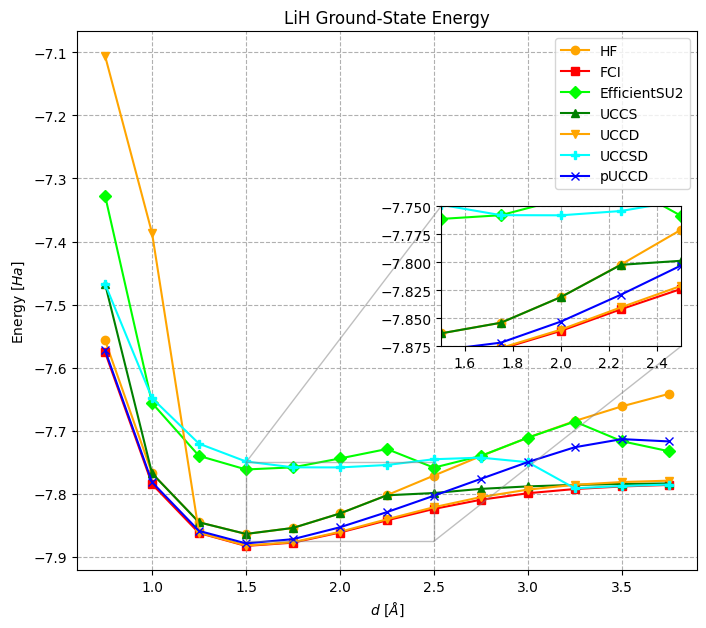

In [22]:
# Zoom sul minimo 1.25<x<1.8 e -7.9<y<-7.85
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met, style in zip(arr_methods,arr_style):  
    plt.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.58, .43, .3, .2]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=1.5,xmax=2.5)
ax_inset.axis(ymin=-7.875,ymax=-7.75)

for met, style in zip(arr_methods,arr_style):  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()

## Senza UCCD

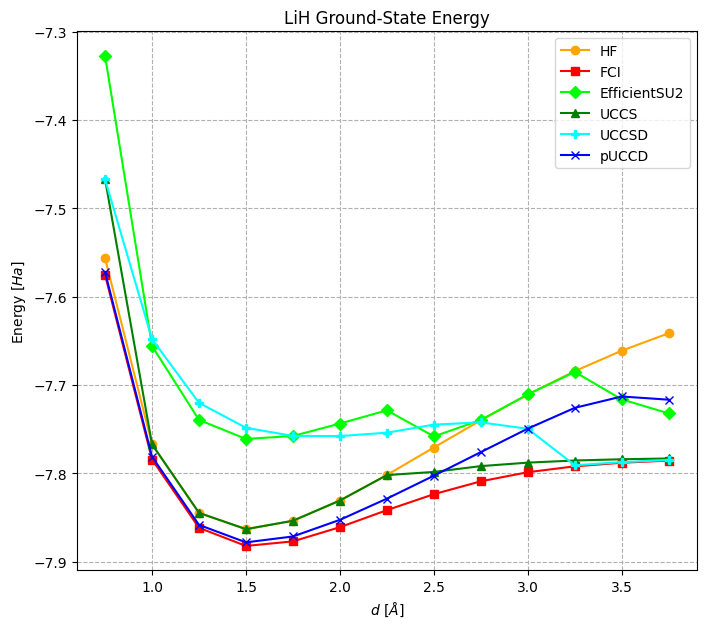

In [23]:
fig, ax = plt.subplots(figsize=[8, 7])

for met, style in zip(arr_methods, arr_style):  
    if met != 'UCCD':
        ax.plot(arr_distance, arr_ground_energy[met], label=met, color=style[0], marker=style[1])

# Aggiungi etichette e titolo
ax.set_title("LiH Ground-State Energy")
ax.set_xlabel(r"$d$ $[\AA]$")
ax.set_ylabel(r"Energy $[Ha]$")
ax.grid(linestyle='--')
ax.legend()

plt.show()

In [24]:
arr_intermediate

{'EfficientSU2': [], 'UCCS': [], 'UCCD': [], 'UCCSD': [], 'pUCCD': []}

# Convergenza

In [25]:
# non c'è niente nei vettori intermedi...